## $\textbf{Input}$

In [ ]:
stock_symbl = 'AMZN'
data_file = 'data_amzn.csv'

## $\textbf{Imports}$

In [ ]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from datetime import date, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
 
from sklearn.metrics import mean_squared_error
plt.style.use('ggplot')
 
!pip install alpha_vantage
import requests

## $\textbf{Downloading fundamental Data into dataframe}$

In [ ]:

API_URL = "https://www.alphavantage.co/query" 


data_earnings = { 
    "function": 'EARNINGS', 
    "symbol": stock_symbl,
    "outputsize" : "compact",
    "datatype": "json", 
    "apikey": '0J60AGKUN42KGVXB'} 

response_earnings = requests.get(API_URL, data_earnings) 
response_earnings_json = response_earnings.json()

earnings_df = pd.DataFrame(response_earnings_json['quarterlyEarnings'])
earnings_df.set_index('fiscalDateEnding',inplace=True)


eps = earnings_df[['reportedEPS']]
eps


data_inc = { 
    "function": 'INCOME_STATEMENT', 
    "symbol": stock_symbl,
    "outputsize" : "full",
    "datatype": "pandas", 
    "apikey": '0J60AGKUN42KGVXB'} 

response_inc = requests.get(API_URL, data_inc) 
response_inc_json = response_inc.json()


inc_dic = {
            'fiscalDateEnding' : [],
            'operatingIncome' : [],
            'grossProfit': [],
            'totalRevenue' :[]
          }

for i in range(len(response_inc_json['quarterlyReports'])):
  inc_dic['fiscalDateEnding'].append(response_inc_json['quarterlyReports'][i]['fiscalDateEnding'])
  inc_dic['operatingIncome'].append(10e-6*float(response_inc_json['quarterlyReports'][i]['operatingIncome']))
  inc_dic['grossProfit'].append(10e-6*float(response_inc_json['quarterlyReports'][i]['grossProfit']))
  inc_dic['totalRevenue'].append(10e-6*float(response_inc_json['quarterlyReports'][i]['totalRevenue']))

income_stmt = pd.DataFrame(inc_dic)
income_stmt.set_index('fiscalDateEnding', inplace=True)

new_inc = pd.read_csv(data_file)
new_inc.dropna(axis=1, inplace=True)

new_inc.columns = ['fiscalDateEnding', 'totalRevenue', 'grossProfit', 'operatingIncome']
new_inc.set_index('fiscalDateEnding',inplace=True)


income_stmt = income_stmt.append(new_inc)
#income_stmt


In [ ]:
income_stmt

,operatingIncome,grossProfit,totalRevenue
fiscalDateEnding,,,
2021-03-31,88650.0,350350.0,1080880.0
2020-12-31,68730.0,227350.0,1251760.0
2020-09-30,61940.0,293110.0,957170.0
2020-06-30,58430.0,889120.0,889120.0
2020-03-31,39890.0,223970.0,748280.0
2019-12-31,38790.0,110550.0,869610.0
2019-09-30,31570.0,195750.0,695860.0
2019-06-30,30840.0,634040.0,634040.0
2019-03-31,44200.0,597000.0,597000.0


## $\textbf{Defining fucntions}$

In [ ]:
def calculate_rsi(close_price_df, period=14):
  '''
  This function calculated the Relative Strength Index (RSI) from the prices. The defualt period to calculate RSI
  has been set to 14. 
  
  Parameters:

  close_price_df: It should be a dataframe with only one column that contains the close prices of the stock. This dataframe
                  must contain the date as index. Because this function when used inside other functions, helps in joining dataframe
                  on date index (datetime object). Hence if the index is not date then it would create problems while joining thid with other datafrae.
  period :(use int) This is the period using which RSI is calculated. If any other data type is used, it will be converted to int
  '''
  period = int(period)

  rsi_dummy = close_price_df.copy(True)
  rsi_dummy.dropna(axis=0, inplace=True)
  rsi_dummy['Change'] = rsi_dummy.iloc[:,[0]] - rsi_dummy.iloc[:,[0]].shift(1)
  rsi_dummy['Gain'] = np.where(rsi_dummy['Change']>0,rsi_dummy['Change'],0)
  rsi_dummy['Loss'] = np.where(rsi_dummy['Change']<0,-rsi_dummy['Change'],0)
  avg_gain = []
  avg_loss = []

  for i in range(len(rsi_dummy)):
    if (i<(period-1)):
      avg_gain.append(np.NaN)
      avg_loss.append(np.NaN)
    elif i==(period-1):
      avg_gain.append((rsi_dummy['Gain'][0:period].values.sum())/period)
      avg_loss.append((rsi_dummy['Loss'][0:period].values.sum())/period)
    else:
      avg_gain.append( (avg_gain[i-1]*(period-1) + rsi_dummy['Gain'][i] )/period   )
      avg_loss.append( (avg_loss[i-1]*(period-1) + rsi_dummy['Loss'][i] )/period   )

  rsi_dummy['Avg_gain'] = np.array(avg_gain)
  rsi_dummy['Avg_loss'] = np.array(avg_loss)
  rsi_dummy['RS'] = rsi_dummy['Avg_gain'] / rsi_dummy['Avg_loss']
  rsi_dummy['RSI'] = np.where(rsi_dummy['Avg_loss']==0,100, 100-(100/(1+rsi_dummy['RS'])) )
  rsi_dummy = rsi_dummy.dropna(axis=0)
  return rsi_dummy[['RSI']]



def calculate_MACD(data_df,fast_period=12 , slow_period=26, signal_period=9 ):
  '''
  This function calculates the the four colums, macd_fast, macd_sloe, macd, and macd_signal. For clearer understanding read how macd is calculated.
  The parameters are simply the periods of the fast, slow, and signal exponential averages.

  The default values for fast_period, slow_period and signal_period are 12, 26 and 9 respectively.

  The data_df should be a dataframe with index as date time object and it should only contain one column for the closing price of the stock, on which
  the macd moving averages will be calculated. If you want to calculate the same averages and signal on opening prices, or high, or low, then you can
  replace the closing price, column with that.
  '''

  fast_period = int(fast_period)
  slow_period = int(slow_period)
  signal_period = int(signal_period)

  macd = data_df.iloc[:,[0]].copy(True)
  macd = macd.dropna(axis=0)
  macd['macd_fast'] = macd.iloc[:,[0]].ewm(span=fast_period, min_periods=fast_period).mean()
  macd['macd_slow'] = macd.iloc[:,[0]].ewm(span=slow_period, min_periods=slow_period).mean()
  macd['MACD'] = macd['macd_fast'] - macd['macd_slow']
  macd['macd_signal'] = macd['MACD'].ewm(span=signal_period, min_periods=signal_period).mean()
  macd = macd.dropna(axis=0)
  
  return macd[['macd_fast', 'macd_slow', 'MACD', 'macd_signal']]



def calculate_ATR(data_df, atr_period=14):
  '''
  ATR calculated the Average True range. atr_period is the period according to which the moving average is calculated.
  The default is 14.

  data_df should be a dataframe with index as a datetime object so that you can easily join this later with your data.
  data_df should contain the following columns, 'High', 'Low', 'Adj Close', they can be in any order.
  '''

  atr_period = int(atr_period)

  atr_df = data_df.copy(True)
  atr_df = atr_df.dropna(axis=0)

  atr_df['H-L'] = abs(atr_df['High'] - atr_df['Low'])
  atr_df['H-Cp'] = abs(atr_df['High'] - atr_df['Adj Close'].shift(1))
  atr_df['L-Cp'] = abs(atr_df['Low'] - atr_df['Adj Close'].shift(1))
  atr_df['TR']  = atr_df[['H-L', 'H-Cp', 'L-Cp']].max(axis=1, skipna=False)
  atr_df['ATR'] = atr_df['TR'].rolling(atr_period).mean()
  atr_df = atr_df.dropna(axis=0)

  return atr_df[['ATR']]



def calculate_OBV(data_df):
  '''
  This function calculated the On-Balace Volume(OBV) from the given data.
  data_df must be a dataframe with these two columns, 'Adj Close' and 'Volume'

  '''
  obv_df = data_df.copy(True)
  obv_df = obv_df.dropna(axis=0)
  obv_df['rtn'] = obv_df['Adj Close'].pct_change()
  obv_df['Adj_volume'] = np.where(obv_df['rtn']>0, obv_df['Volume'], -obv_df['Volume'])
  obv_df['Adj_volume'][0] = 0
  obv_df['OBV'] = obv_df['Adj_volume'].cumsum()
  obv_df = obv_df.dropna(axis=0)

  return obv_df[['OBV']]



def calculate_Bollinger_Band(data_df, bb_sma_period=20):
  '''
  This function calculate the bollinger band for th given data.

  data_df must be a dataframe with only close price as the column 
    (Should contain only one column, The function takes the first column 
    as the close 
    prices). And the index of the data_df should be a datetime object for further convenienceto join the dataframe.

  bb_sma_period is the simple moving average period to calculate the bollinger band. 
  '''
  bb_sma_period = int(bb_sma_period)
  bb_df = data_df.copy(True)
  bb_df = bb_df.dropna(axis=0)

  bb_df['MA'] = bb_df.iloc[:,[0]].rolling(bb_sma_period).mean()
  bb_df['BB_upper'] = bb_df['MA'] + 2*bb_df['MA'].rolling(bb_sma_period).std()
  bb_df['BB_lower'] = bb_df['MA'] - 2*bb_df['MA'].rolling(bb_sma_period).std()
  bb_df = bb_df.dropna(axis=0)

  return bb_df[['BB_upper', 'BB_lower']]




def calculate_ADX(data_df, adx_period=14):
  '''
  This function calculated the Average Directional index (ADX). 

  data_df : Must be a dataframe with columns, 'High', 'Low', and 'Adj Close'. Index must be a datetime object (date)

  '''
  adx_period = int(adx_period) 
  adx_df = data_df.copy(True)
  adx_df = adx_df.dropna(axis=0)

  adx_df['H-L'] = abs(adx_df['High'] - adx_df['Low'])
  adx_df['H-Cp'] = abs(adx_df['High'] - adx_df['Adj Close'].shift(1))
  adx_df['L-Cp'] = abs(adx_df['Low'] - adx_df['Adj Close'].shift(1))
  adx_df['TR']  = adx_df[['H-L', 'H-Cp', 'L-Cp']].max(axis=1, skipna=False)
  adx_df['+DM_1'] = np.where((adx_df['High']-adx_df['High'].shift(1)) >( adx_df['Low'].shift(1) -adx_df['Low']), adx_df['High']-adx_df['High'].shift(1), 0 )
  adx_df['+DM_1'] = np.where(adx_df['+DM_1']<0, 0 ,adx_df['+DM_1'])
  adx_df['-DM_1'] = np.where((adx_df['Low'].shift(1)-adx_df['Low'])>(adx_df['High']-adx_df['High'].shift(1)),adx_df['Low'].shift(1)-adx_df['Low'],0)
  adx_df['-DM_1'] = np.where(adx_df['-DM_1'] <0, 0,adx_df['-DM_1'])
  adx_df['+DM_1'][0] = np.NaN
  adx_df['-DM_1'][0] = np.NaN

  TR_N = []
  DM_plus_N = []
  DM_minus_N = []

  for i in range(len(adx_df)):
    if i < (adx_period):
      TR_N.append(np.NaN)
      DM_plus_N.append(np.NaN)
      DM_minus_N.append(np.NaN)
    elif i == (adx_period):
      TR_N.append(adx_df['TR'][:adx_period+1].sum())
      DM_plus_N.append(adx_df['+DM_1'][:adx_period+1].sum())
      DM_minus_N.append(adx_df['-DM_1'][:adx_period+1].sum())
    else:
      TR_N.append(TR_N[i-1]*((adx_period-1)/adx_period) + adx_df['TR'][i] )
      DM_plus_N.append(DM_plus_N[i-1]*((adx_period-1)/adx_period) + adx_df['+DM_1'][i] )
      DM_minus_N.append(DM_minus_N[i-1]*((adx_period-1)/adx_period) + adx_df['-DM_1'][i] )

  adx_df['TR_N'] = np.array(TR_N)
  adx_df['+DM_N'] = np.array(DM_plus_N)
  adx_df['-DM_N'] = np.array(DM_minus_N)

  adx_df['+DI_N'] = 100* adx_df['+DM_N'] / adx_df['TR_N']
  adx_df['-DI_N'] = 100* adx_df['-DM_N'] / adx_df['TR_N']
  adx_df['Diff_DI_N'] = abs(adx_df['+DI_N'] - adx_df['-DI_N'])
  adx_df['Sum_DI_N'] = (adx_df['+DI_N'] + adx_df['-DI_N'])
  adx_df['DX'] = 100* adx_df['Diff_DI_N'] / adx_df['Sum_DI_N']

  ADX = []

  for i in range(len(adx_df)):
    if i <(2*adx_period-1):
      ADX.append(np.NaN)
    elif i==(2*adx_period-1):
      ADX.append(np.mean(adx_df['DX'][i-adx_period+1 : i+1]))
    else:
      ADX.append( ((adx_period-1)*ADX[i-1] + adx_df['DX'][i])/adx_period )


  adx_df['ADX'] = np.array(ADX)
  #adx_df = adx_df.dropna(axis=0)

  return adx_df['ADX']





  



In [ ]:


def download_and_transform_data(stock_ticker,
                                predict_close=True,                                
                                
                                look_back_period_close = 0,
                                look_back_period_open =0 ,
                                sma_freq_close = [],
                                sma_freq_open = [],

                                add_eps = False, eps_df=None,
                                add_income_stmt = False ,income_stmt_df =None,
                                
                                add_RSI = True, rsi_period=14,
                                add_MACD = True, macd_fst_slw_sig = [12,26,9],
                                add_ATR = True, atr_period =14,
                                add_OBV = True,
                                add_ADX = True, adx_period = 14,
                                add_BBand = True, bb_period = 20,
                                
                                ):
  '''
  This function downloads the data from yahoo and then convert that data into matrix form. First of all it converts the data so that the 
  the target value, i.e the close price is predicted on the basis of the previous day's open high low volumne and then it uses the lookback period
  to create the columns of the lookback. It then uses the list sma_freq to calculate the simple moving average columns accordint to the given freq
  LAstly it splits the data into train and test set for the model traingn and testing.
  '''
  
  start = date(2008,1,1)
  
  data_df = web.DataReader(name=stock_ticker, data_source='yahoo', start=start, end=date.today())

  
  if predict_close==True:
    predictor = 'Adj Close'
    not_predictor = 'Open'
  else:
    predictor = 'Open'
    not_predictor = 'Adj Close'


  dummy_ = data_df.drop('Close',axis=1,)[['High', 'Low', not_predictor, 'Volume']]
  dummy_ = dummy_.shift(1)
  dummy_[predictor] = data_df[predictor]
  dummy_ = dummy_[1:]

  for i in range(look_back_period_close):
    dummy_['Close_t-{}'.format(i+1)] = dummy_['Adj Close'].shift(i+1)

  for i in range(look_back_period_open):
    dummy_['Open_t-{}'.format(i+1)] = dummy_['Open'].shift(i+1)

  for frq in sma_freq_close:
    dummy_['SMA_Close_{}'.format(frq)] = dummy_['Adj Close'].rolling(frq).mean()

  for frq in sma_freq_open:
    dummy_['SMA_Open_{}'.format(frq)] = dummy_['Open'].rolling(frq).mean()

  if add_eps==True:
    dummy_ = dummy_.join(eps_df, how='outer')
    dummy_['reportedEPS'].fillna(method='ffill', inplace=True)

  if add_income_stmt==True:
    dum = dummy_.join(income_stmt_df, how='outer')
    dum['operatingIncome'].fillna(method='ffill', inplace=True)
    dum['grossProfit'].fillna(method='ffill', inplace=True)
    dum['totalRevenue'].fillna(method='ffill', inplace=True)

  if add_RSI==True:
    dum = dum.join(calculate_rsi(dum[['Adj Close']],
                                 int(rsi_period)
                                 ))

  if add_MACD==True:
    dum = dum.join(calculate_MACD(dum[['Adj Close']],
                                  int(macd_fst_slw_sig[0]),
                                  int(macd_fst_slw_sig[1]),
                                  int(macd_fst_slw_sig[2]),
                                  ))
    
  if add_ATR==True:
    dum = dum.join(calculate_ATR(dum[['High', 'Low', 'Adj Close']], int(atr_period)))

  if add_OBV==True:
    dum = dum.join(calculate_OBV(dum[['Adj Close', 'Volume']]))

  if add_BBand==True:
    dum = dum.join(calculate_Bollinger_Band(dum[['Adj Close']],
                                            int(bb_period)
                                            ))

  if add_ADX==True:
    dum = dum.join(calculate_ADX(dum[['High', 'Low', 'Adj Close', 'Volume']],int(adx_period)))
  
  dummy_ = dum.dropna(axis=0)

  return data_df, dummy_

###################################################################################

def create_train_test_split(data,predict_close =True,
                            train_size =0.75, 
                            val_size =0.15, 
                            print_rslt=False 
                            ):

  test_size = 1 - train_size - val_size

  assert all( x >=0 for x in [train_size, val_size, test_size]) 
  assert all( x <=1 for x in [train_size, val_size, test_size]) 
  assert (train_size + val_size + test_size) == 1

  if predict_close==True:
    predictor = 'Adj Close'
    not_predictor = 'Open'
  else:
    predictor = 'Open'
    not_predictor = 'Adj Close'
    

  train_split = data[:int(train_size*len(data))]
  val_split   = data[int(train_size*len(data)):int((train_size + val_size)*len(data))]
  test_split =  data[int((train_size + val_size)*len(data)):]

  train_x = train_split.drop(predictor, axis=1)
  train_y = train_split[[predictor]]

  val_x = val_split.drop(predictor, axis=1)
  val_y = val_split[[predictor]]

  test_x = test_split.drop(predictor, axis=1)
  test_y = test_split[[predictor]]

  if print_rslt ==True:
    print('x train shape:', train_x.shape)
    print('y train shape:', train_y.shape)
    print('x val shape:', val_x.shape)
    print('y val shape:', val_y.shape)
    print('x test shape:', test_x.shape)
    print('y test shape:', test_y.shape)

  return [train_x, train_y, val_x, val_y, test_x, test_y]

  

## $\textbf{Getting Data and preprocessing}$

In [ ]:
stock_orig , stock_data= download_and_transform_data(stock_symbl,                                                   
                                                     
                                                     look_back_period_close=0, 
                                                     sma_freq_close=[20,50,80,100,200],
                                                     predict_close=True,
                                                     add_income_stmt=True, income_stmt_df =income_stmt,                                                      
                                                    
                                                     )


In [ ]:
# plt.figure(figsize= (16,8))
# plt.plot(stock_orig['Adj Close'])
# plt.xlabel('Time', fontsize=16)
# plt.ylabel('Stock Price', fontsize=16)
# plt.title('{} stock price'.format(stock_symbl), fontsize=18)

In [ ]:
tt = create_train_test_split(stock_data)

In [ ]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(tt[0])
y_train = tt[1]

X_val = scaler.transform(tt[2])
y_val = tt[3]

X_test  = scaler.transform(tt[4])
y_test  = tt[5]

print('Scaled X_train Shape :', X_train.shape)
print('Scaled y_train Shape :', y_train.shape)
print('\n')
print('Scaled X_val Shape :', X_val.shape)
print('Scaled y_val Shape :', y_val.shape)
print('\n')
print('Scaled X_test Shape :', X_test.shape)
print('Scaled y_test Shape :', y_test.shape)


Scaled X_train Shape : (1764, 22)
Scaled y_train Shape : (1764, 1)


Scaled X_val Shape : (352, 22)
Scaled y_val Shape : (352, 1)


Scaled X_test Shape : (236, 22)
Scaled y_test Shape : (236, 1)


In [ ]:
X_sclaed = np.append(X_train, np.append(X_val, X_test, axis=0)  ,axis=0)


## $\textbf{SVR}$

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

svr_reg = SVR()
params = {'kernel' :['linear', 'rbf'], 'gamma':[1e-20, 1e-18,1e-16, 1e-14], 'C':[1500,1800,2000,2200,2400,2600]}
grid_svr = GridSearchCV(svr_reg,params,scoring='neg_mean_squared_error',cv=8, verbose=4)
grid_svr.fit(X_train, np.ravel(y_train))

Fitting 8 folds for each of 48 candidates, totalling 384 fits
[CV] C=1500, gamma=1e-20, kernel=linear ..............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1500, gamma=1e-20, kernel=linear, score=-11.087, total=   3.7s
[CV] C=1500, gamma=1e-20, kernel=linear ..............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


[CV] . C=1500, gamma=1e-20, kernel=linear, score=-5.243, total=   2.2s
[CV] C=1500, gamma=1e-20, kernel=linear ..............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.8s remaining:    0.0s


[CV]  C=1500, gamma=1e-20, kernel=linear, score=-11.343, total=   2.7s
[CV] C=1500, gamma=1e-20, kernel=linear ..............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.5s remaining:    0.0s


[CV]  C=1500, gamma=1e-20, kernel=linear, score=-10.216, total=   2.2s
[CV] C=1500, gamma=1e-20, kernel=linear ..............................
[CV]  C=1500, gamma=1e-20, kernel=linear, score=-60.478, total=   2.0s
[CV] C=1500, gamma=1e-20, kernel=linear ..............................
[CV]  C=1500, gamma=1e-20, kernel=linear, score=-27.163, total=   2.4s
[CV] C=1500, gamma=1e-20, kernel=linear ..............................
[CV]  C=1500, gamma=1e-20, kernel=linear, score=-82.726, total=   2.6s
[CV] C=1500, gamma=1e-20, kernel=linear ..............................
[CV]  C=1500, gamma=1e-20, kernel=linear, score=-820.656, total=   2.1s
[CV] C=1500, gamma=1e-20, kernel=rbf .................................
[CV]  C=1500, gamma=1e-20, kernel=rbf, score=-129032.940, total=   0.2s
[CV] C=1500, gamma=1e-20, kernel=rbf .................................
[CV]  C=1500, gamma=1e-20, kernel=rbf, score=-90745.886, total=   0.2s
[CV] C=1500, gamma=1e-20, kernel=rbf .................................
[CV]

[Parallel(n_jobs=1)]: Done 384 out of 384 | elapsed: 10.3min finished


GridSearchCV(cv=8, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1500, 1800, 2000, 2200, 2400, 2600],
                         'gamma': [1e-20, 1e-18, 1e-16, 1e-14],
                         'kernel': ['linear', 'rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=4)

In [ ]:
grid_svr.best_params_


{'C': 2600, 'gamma': 1e-20, 'kernel': 'linear'}

In [ ]:
y_predic_svr = grid_svr.predict(X_val)
print('Train MSE :', mean_squared_error(np.ravel(y_train), grid_svr.predict(X_train)))
print('Val MSE :', mean_squared_error(np.ravel(y_val), y_predic_svr))
print('Test MSE :', mean_squared_error(np.ravel(y_test),grid_svr.predict(X_test)))

Train MSE : 72.30711076238613
Val MSE : 358.2951033133546
Test MSE : 1060.9143161211548


In [ ]:
#np.ravel(grid_svr.best_estimator_.coef_)

Text(0.5, 1.0, 'Feature Importance AMZN')

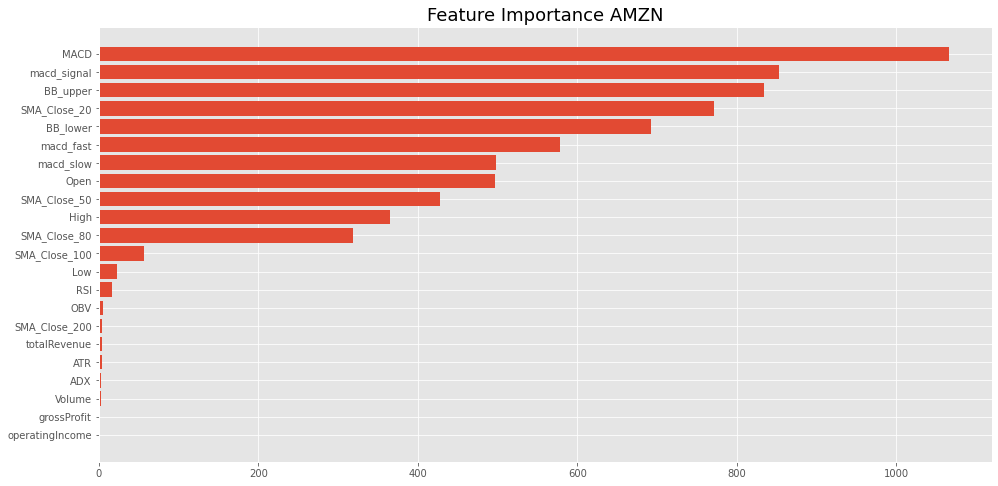

In [ ]:
zip_df = pd.DataFrame( zip(tt[0].columns.tolist(), np.ravel(grid_svr.best_estimator_.coef_)), columns=['Name', 'Coef'])
zip_df['Abs_coef'] = abs(zip_df['Coef'])

plt.figure(figsize=(16,8))
plt.barh(zip_df.sort_values('Abs_coef')['Name'], zip_df.sort_values('Abs_coef')['Abs_coef']         )
plt.title('Feature Importance {}'.format(stock_symbl), fontsize=18)

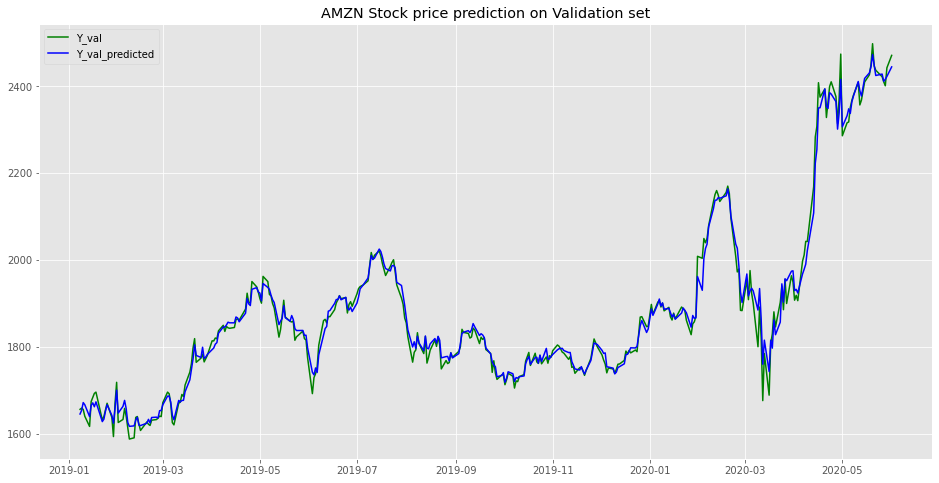

In [ ]:
y_rand_svr = y_val.copy(True)
y_rand_svr['y_val_predicted'] = y_predic_svr
y_rand_svr.rename(columns={'Adj Close' : 'y_val'}, inplace=True)

plt.figure(figsize=(16,8))
plt.plot(y_rand_svr.iloc[:,0], 'g-', label='Y_val')
plt.plot(y_rand_svr.iloc[:,1], 'b-', label='Y_val_predicted')
plt.title('{} Stock price prediction on Validation set'.format(stock_symbl))
plt.legend()

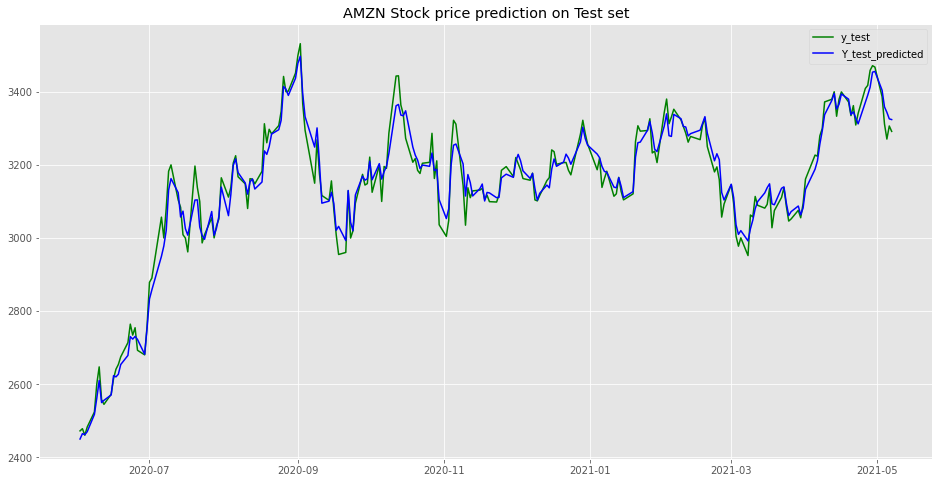

In [ ]:

# plt.figure(figsize=(16,8))
# plt.plot(stock_data['Adj Close'], 'g-', label='Stock_Price')
# plt.plot(pd.DataFrame(grid_svr.predict(X_sclaed), index=stock_data.index), 'b-', label='Y_val_predicted')
# plt.legend()

plt.figure(figsize=(16,8))
plt.plot(y_test, 'g-', label='y_test')
plt.plot(pd.DataFrame(grid_svr.predict(X_test), index=y_test.index), 'b-', label='Y_test_predicted')
plt.title('{} Stock price prediction on Test set'.format(stock_symbl))
plt.legend()

## $\textbf{LGBM}$

In [ ]:
from lightgbm import LGBMRegressor

model_lgbm = LGBMRegressor(n_estimators=100000,
                           learning_rate=0.01,
                           max_depth=15,
                           class_weight = 'balanced',


                           )

model_lgbm.fit(X_train, np.ravel(y_train), categorical_feature=[9,10,11])



/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [9, 10, 11]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


LGBMRegressor(boosting_type='gbdt', class_weight='balanced',
              colsample_bytree=1.0, importance_type='split', learning_rate=0.01,
              max_depth=15, min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100000, n_jobs=-1, num_leaves=31,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [ ]:
y_predic_lgbm = model_lgbm.predict(X_val)
mean_squared_error(y_val, y_predic_lgbm)

18558.908720940697

In [ ]:
y_rand = y_val.copy(True)
y_rand['y_val_predicted'] = y_predic_lgbm
y_rand

,Adj Close,y_val_predicted
2019-01-08,1656.579956,1653.751964
2019-01-09,1659.420044,1676.003118
2019-01-10,1656.219971,1670.076162
2019-01-11,1640.560059,1655.164421
2019-01-14,1617.209961,1626.721107
...,...,...
2020-05-26,2421.860107,1976.218591
2020-05-27,2410.389893,1973.371598
2020-05-28,2401.100098,1973.093813
2020-05-29,2442.370117,1982.536497


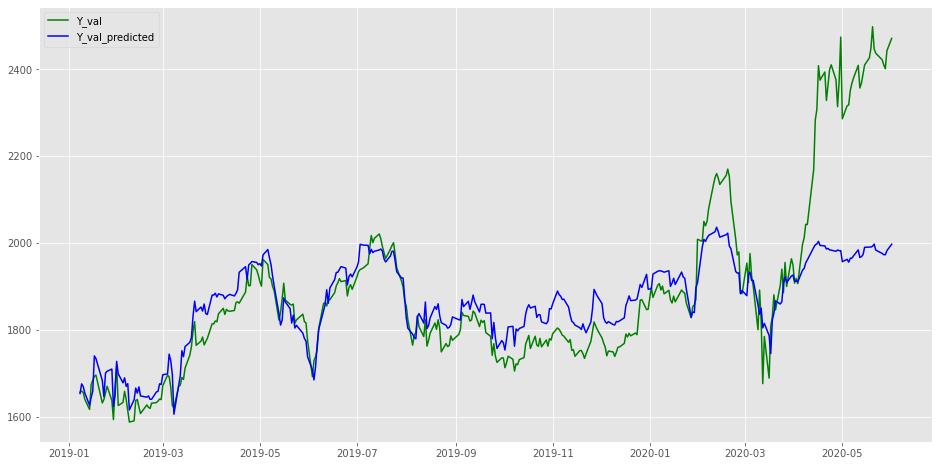

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_rand.iloc[:,0], 'g-', label='Y_val')
plt.plot(y_rand.iloc[:,1], 'b-', label='Y_val_predicted')
plt.legend()

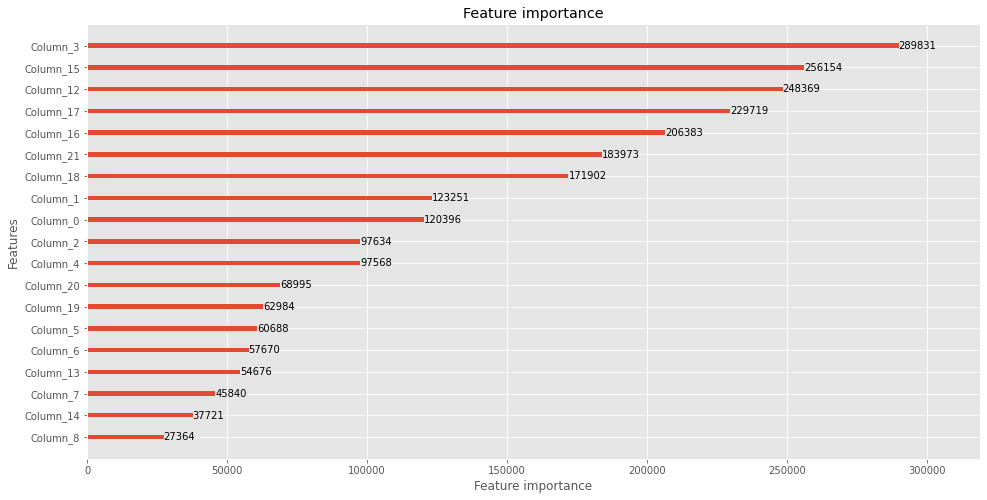

In [ ]:
from lightgbm import plot_importance

fig , ax = plt.subplots(figsize=(16,8))
plot_importance(model_lgbm,ax=ax)

In [ ]:
tt[2].iloc[:,[15,12,3,6,16,21,18,17,0,1,2]]

,MACD,RSI,Volume,SMA_Close_80,macd_signal,ADX,OBV,ATR,High,Low,Open
2019-01-08,-10.741722,58.103919,7993200.0,1701.842755,-34.137467,22.575788,83965100.0,74.310006,1634.560059,1589.189941,1602.310059
2019-01-09,-1.310366,58.310560,8881400.0,1697.712131,-27.572047,21.874671,92846500.0,73.515721,1676.609985,1616.609985,1664.689941
2019-01-10,5.838529,57.963654,6348800.0,1693.787506,-20.889932,21.223634,86497700.0,72.220006,1667.800049,1641.400024,1652.979980
2019-01-11,10.123755,56.201573,6507700.0,1690.444131,-14.687194,20.286055,79990000.0,67.954293,1663.250000,1621.619995,1641.010010
2019-01-14,11.503070,53.585778,4686200.0,1686.396130,-9.449141,19.415445,75303800.0,64.187151,1660.290039,1636.219971,1640.550049
...,...,...,...,...,...,...,...,...,...,...,...
2020-05-26,59.928017,57.409623,2867100.0,2123.618875,67.326084,28.944812,253415200.0,48.506417,2469.850098,2430.129883,2455.010010
2020-05-27,54.995781,56.047527,3568200.0,2128.639749,64.860023,29.062240,249847000.0,48.797119,2462.000000,2414.060059,2458.000000
2020-05-28,49.763696,54.911201,5056900.0,2133.601001,61.840758,27.453962,244790100.0,52.092128,2413.580078,2330.000000,2404.989990
2020-05-29,48.389571,58.897987,3190200.0,2138.509753,59.150520,26.309575,247980300.0,53.938564,2436.969971,2378.229980,2384.330078


In [ ]:
tt[2].iloc[:,[5,19,13,4,20,6,14,8,7,11]]

,SMA_Close_50,BB_upper,macd_fast,SMA_Close_20,BB_lower,SMA_Close_80,macd_slow,SMA_Close_200,SMA_Close_100,totalRevenue
2019-01-08,1595.155208,1601.051458,1551.165719,1538.061499,1475.071540,1701.842755,1561.907442,1700.797702,1750.066604,717900.0
2019-01-09,1592.700208,1603.871206,1567.820231,1538.981000,1474.090793,1697.712131,1569.130597,1701.617002,1747.834604,717900.0
2019-01-10,1592.968406,1605.620860,1581.420191,1539.629999,1473.639137,1693.787506,1575.581662,1702.118802,1745.531604,717900.0
2019-01-11,1595.002007,1604.541918,1590.518632,1538.481000,1472.420081,1690.444131,1580.394877,1702.836352,1743.115005,717900.0
2019-01-14,1596.737805,1601.529445,1594.624990,1536.422498,1471.315550,1686.396130,1583.121920,1703.765302,1740.520005,717900.0
...,...,...,...,...,...,...,...,...,...,...
2020-05-26,2199.693403,2510.676727,2416.571540,2389.530518,2268.384309,2123.618875,2356.643523,1926.621948,2074.497799,748280.0
2020-05-27,2214.118201,2500.154902,2415.620517,2394.346008,2288.537115,2128.639749,2360.624736,1929.635998,2079.621598,748280.0
2020-05-28,2225.983403,2486.305321,2413.386607,2395.765515,2305.225709,2133.601001,2363.622911,1932.716898,2084.882899,748280.0
2020-05-29,2238.230806,2471.792730,2417.845608,2394.184021,2316.575312,2138.509753,2369.456037,1935.807049,2090.277800,748280.0


## $\textbf{XGBoost}$

In [ ]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(n_estimators=1000,
                         learning_rate=0.01,
                         max_depth=5
                         )
model_xgb.fit(tt[0], np.ravel(y_train))

[15:55:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [ ]:
y_predic_xgb = model_xgb.predict(tt[2])
print('Train MSE :', mean_squared_error(np.ravel(y_train), grid_svr.predict(tt[0])))
print('Val MSE :', mean_squared_error(np.ravel(y_val), y_predic_xgb))

Train MSE : 2.3249808554151695e+18
Val MSE : 20074.813240426764


## $\textbf{Catboost}$

In [ ]:
!pip install catboost
from catboost import CatBoostRegressor

     |████████████████████████████████| 67.3MB 76kB/s 


In [ ]:
model_cat = CatBoostRegressor(iterations=10000,
                              learning_rate =0.01,
                              )
model_cat.fit(tt[0], np.ravel(y_train))

Streaming output truncated to the last 5000 lines.
5000:	learn: 2.3309160	total: 32.9s	remaining: 32.9s
5001:	learn: 2.3305566	total: 32.9s	remaining: 32.9s
5002:	learn: 2.3302647	total: 32.9s	remaining: 32.9s
5003:	learn: 2.3299728	total: 32.9s	remaining: 32.9s
5004:	learn: 2.3297316	total: 32.9s	remaining: 32.9s
5005:	learn: 2.3294950	total: 32.9s	remaining: 32.9s
5006:	learn: 2.3293779	total: 32.9s	remaining: 32.8s
5007:	learn: 2.3284344	total: 32.9s	remaining: 32.8s
5008:	learn: 2.3279612	total: 32.9s	remaining: 32.8s
5009:	learn: 2.3272922	total: 33s	remaining: 32.8s
5010:	learn: 2.3267848	total: 33s	remaining: 32.8s
5011:	learn: 2.3261498	total: 33s	remaining: 32.8s
5012:	learn: 2.3257752	total: 33s	remaining: 32.8s
5013:	learn: 2.3253351	total: 33s	remaining: 32.8s
5014:	learn: 2.3250058	total: 33s	remaining: 32.8s
5015:	learn: 2.3246285	total: 33s	remaining: 32.8s
5016:	learn: 2.3244133	total: 33s	remaining: 32.8s
5017:	learn: 2.3238467	total: 33s	remaining: 32.8s
5018:	learn: 

In [ ]:
y_predic_cat = model_cat.predict(tt[2])
print('Train MSE :', mean_squared_error(np.ravel(y_train), grid_svr.predict(tt[0])))
print('Val MSE :', mean_squared_error(np.ravel(y_val), y_predic_cat))

Train MSE : 2.3249808554151695e+18
Val MSE : 52100.20921702527


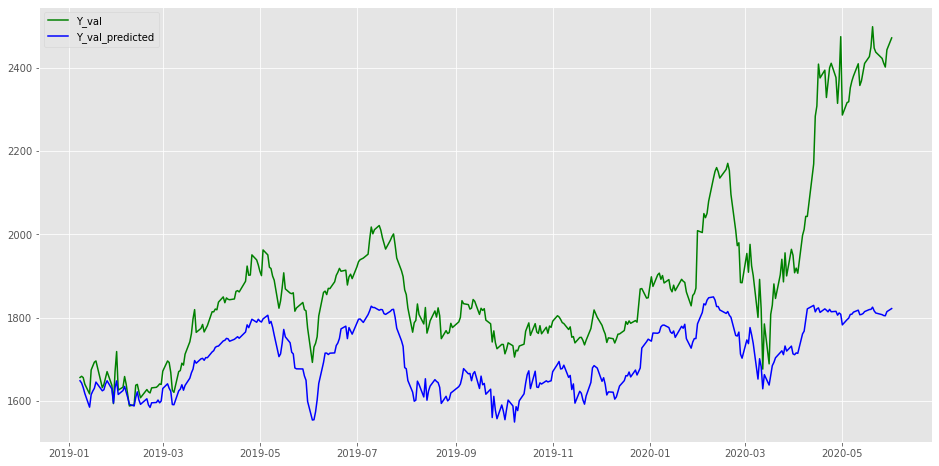

In [ ]:
y_rand_cat = y_val.copy(True)
y_rand_cat['y_val_predicted'] = y_predic_cat
y_rand_cat

plt.figure(figsize=(16,8))
plt.plot(y_rand_cat.iloc[:,0], 'g-', label='Y_val')
plt.plot(y_rand_cat.iloc[:,1], 'b-', label='Y_val_predicted')
plt.legend()

## $\textbf{LSTM}$

In [ ]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_val = X_val.reshape((X_val.shape[0],X_val.shape[1],1))
X_test  = X_test.reshape((X_test.shape[0],X_test.shape[1],1))


In [ ]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

# model = Sequential()
# model.add(LSTM(128, return_sequences=False, input_shape= (X_train.shape[1], 1)))
# model.add(LSTM(64, return_sequences=False))
# model.add(Dense(25))
# model.add(Dense(1))

# # Compile the model
# model.compile(optimizer='adam', loss='mean_absolute_percentage_error') # Change loss to mean absolute error

# # Train the model
# model.fit(X_train, y_train, batch_size=32, epochs=100)



# regressor = Sequential()
# regressor.add(LSTM(units = 2000, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# regressor.add(Dropout(0.2))
# regressor.add(LSTM(units = 200, return_sequences = True))
# regressor.add(Dropout(0.2))
# regressor.add(LSTM(units = 200, return_sequences = True))
# regressor.add(Dropout(0.2))
# regressor.add(LSTM(units = 200))
# regressor.add(Dropout(0.2))
# regressor.add(Dense(units = 1))

# regressor.compile(optimizer = 'adam', loss = 'mean_absolute_percentage_error')
# regressor.fit(X_train, y_train, epochs = 10, batch_size = 64)


model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)  ))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=200,batch_size=32)


Epoch 1/10
56/56 - 5s - loss: 657124.6875
Epoch 2/10
56/56 - 2s - loss: 645047.5625
Epoch 3/10
56/56 - 2s - loss: 637732.0000
Epoch 4/10
56/56 - 2s - loss: 630541.0000
Epoch 5/10
56/56 - 2s - loss: 623686.6250
Epoch 6/10
56/56 - 2s - loss: 616774.6875
Epoch 7/10
56/56 - 2s - loss: 610056.2500
Epoch 8/10
56/56 - 2s - loss: 603468.8125
Epoch 9/10
56/56 - 2s - loss: 596959.7500
Epoch 10/10
56/56 - 2s - loss: 590619.8125


In [ ]:
y_predic_lstm = model.predict(X_val)
mean_squared_error(y_val,y_predic_lstm)

3330847.1392494813

,Adj Close,y_val_predicted
2019-01-08,1656.579956,66.175873
2019-01-09,1659.420044,66.175873
2019-01-10,1656.219971,66.175873
2019-01-11,1640.560059,66.175873
2019-01-14,1617.209961,66.175873
...,...,...
2020-05-26,2421.860107,66.175873
2020-05-27,2410.389893,66.175873
2020-05-28,2401.100098,66.175873
2020-05-29,2442.370117,66.175880


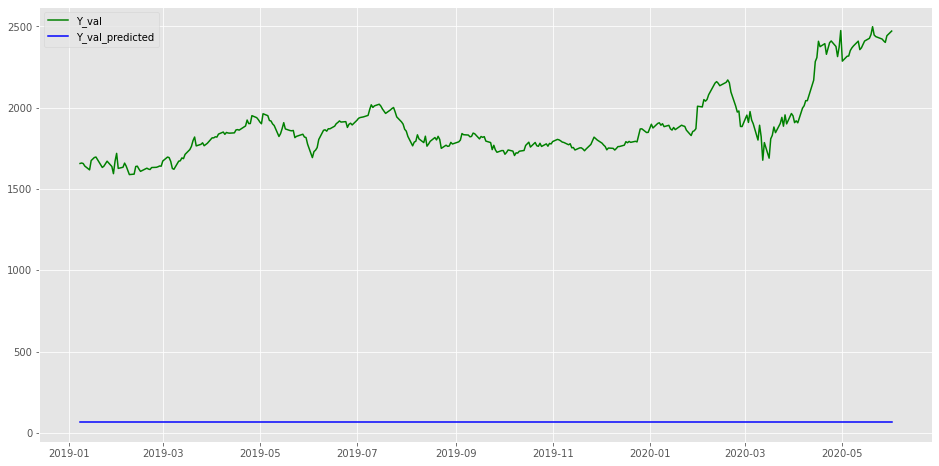

In [ ]:
y_rand_lstm = y_val.copy(True)
y_rand_lstm['y_val_predicted'] = y_predic_lstm

plt.figure(figsize=(16,8))
plt.plot(y_rand_lstm.iloc[:,0], 'g-', label='Y_val')
plt.plot(y_rand_lstm.iloc[:,1], 'b-', label='Y_val_predicted')
plt.legend()

y_rand_lstm